In [10]:
%%capture
%matplotlib inline

# Downloads and imports

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install ogb
!git clone https://github.com/m-k-S/neural-mechanics-geometric.git

import torch
import torch.nn as nn
import torch.nn.functional as F

from ogb.graphproppred import PygGraphPropPredDataset
from torch.utils.data import random_split
from torch_geometric.datasets import TUDataset, QM9, GNNBenchmarkDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader

import networkx as nx
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [15]:
# Hacky but convenient
# Re-run upon code changes to the utilities code (for cleanliness/conciseness)
!cd neural-mechanics-geometric/ && git pull

import sys
sys.path.append('./neural-mechanics-geometric')

from importlib import reload
import order_parameters, data_utils, train, model, data
reload(order_parameters)
reload(data_utils)
reload(train)
reload(model)
reload(data)

from order_parameters import ActivationProbe, ConvolutionProbe
from train import test_classification, train_classification, test_regression, train_regression
from data_utils import initial_order_params, save_order_params, clear_order_params
from model import GraphNet

Already up to date.


In [16]:
### DATASET LOADING ###

# Experiment Parameters
batch_size = 128
restrict = False # restrict the dataset to only graphs with a fixed_nodes number of nodes
fixed_nodes = 12
dataset = 'PROTEINS'
task = 'regression' if dataset == 'QM9' else 'classification'

if dataset == 'QM9':
    dataset = QM9(root='data/QM9')
elif dataset == 'PPA':
    dataset = PygGraphPropPredDataset(name = 'ogbg-ppa')
elif dataset == 'MOLHIV':
    dataset = PygGraphPropPredDataset(name = 'ogbg-molhiv')
elif dataset == 'PROTEINS':
    dataset = TUDataset(root='data/TUDataset', name='PROTEINS_full', use_node_attr=True, transform=NormalizeFeatures())

# Restrict dataset to only graphs with a fixed number of nodes
if restrict:

    restricted_dataset = []
    num_nodes = []
    for d in dataset:
        num_nodes.append(len(d.x))
        if len(d.x) == fixed_nodes:
            restricted_dataset.append(d)

    plt.figure(figsize=(20, 7))
    plt.hist(num_nodes, bins=max(num_nodes))
    plt.xticks(np.arange(1, max(num_nodes), step=1))
    plt.show()

    dataset = restricted_dataset

try:
    split_idx = dataset.get_idx_split() 
    train_loader = DataLoader(dataset[split_idx["train"]], batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset[split_idx["test"]], batch_size=batch_size, shuffle=False)
except AttributeError:
    train_dataset, test_dataset = random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2) + 1], generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
try:
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')
except:
    pass

# print(f'Dataset balance: {dataset.data.y.flatten().bincount()[0] / len(dataset.data.y)}')


Dataset: PROTEINS_full(1113):
Number of graphs: 1113
Number of features: 32
Number of classes: 2


In [18]:
!python --version

Python 3.7.13


In [17]:
### INITIAL ORDER PARAMETERS ### 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_channels = 64
depths = torch.arange(3, 56, 12)

metrics = []

# Loop for getting initial activation and gradient norms (for a full training epoch, i.e. over all samples)

# Iterate over different normalization types
# norms = [None, 'BatchNorm', 'GraphNorm', 'PairNorm', 'DiffGroupNorm']

norms = [None, 'BatchNorm']
for norm_setting in tqdm(norms, desc="Normalization Types", position=0):

    # Iterate over different model depths
    for depth in tqdm(depths, desc="Network Depths", position=1, leave=False):

        if norm_setting == 'BatchNorm' or norm_setting == 'GraphNorm':
            norm_args = {'in_channels': hidden_channels}
        else:
            norm_args = None

        # Define model, optimizer, and loss
        model = GraphNet(
            hidden_channels=hidden_channels, 
            num_input_features = dataset[0].x.shape[-1],
            num_layers=depth, 
            conv_type="GCN",
            task=task, 
            norm=norm_setting, 
            norm_args=norm_args
        ).to(device)            

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        # The mean of the initial activations and gradients are saved in these dictionaries; the keys are the corresponding layers
        m = initial_order_params(model, train_loader, criterion, optimizer, device)
        metrics += m

Normalization Types:   0%|          | 0/2 [00:00<?, ?it/s]

Network Depths:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

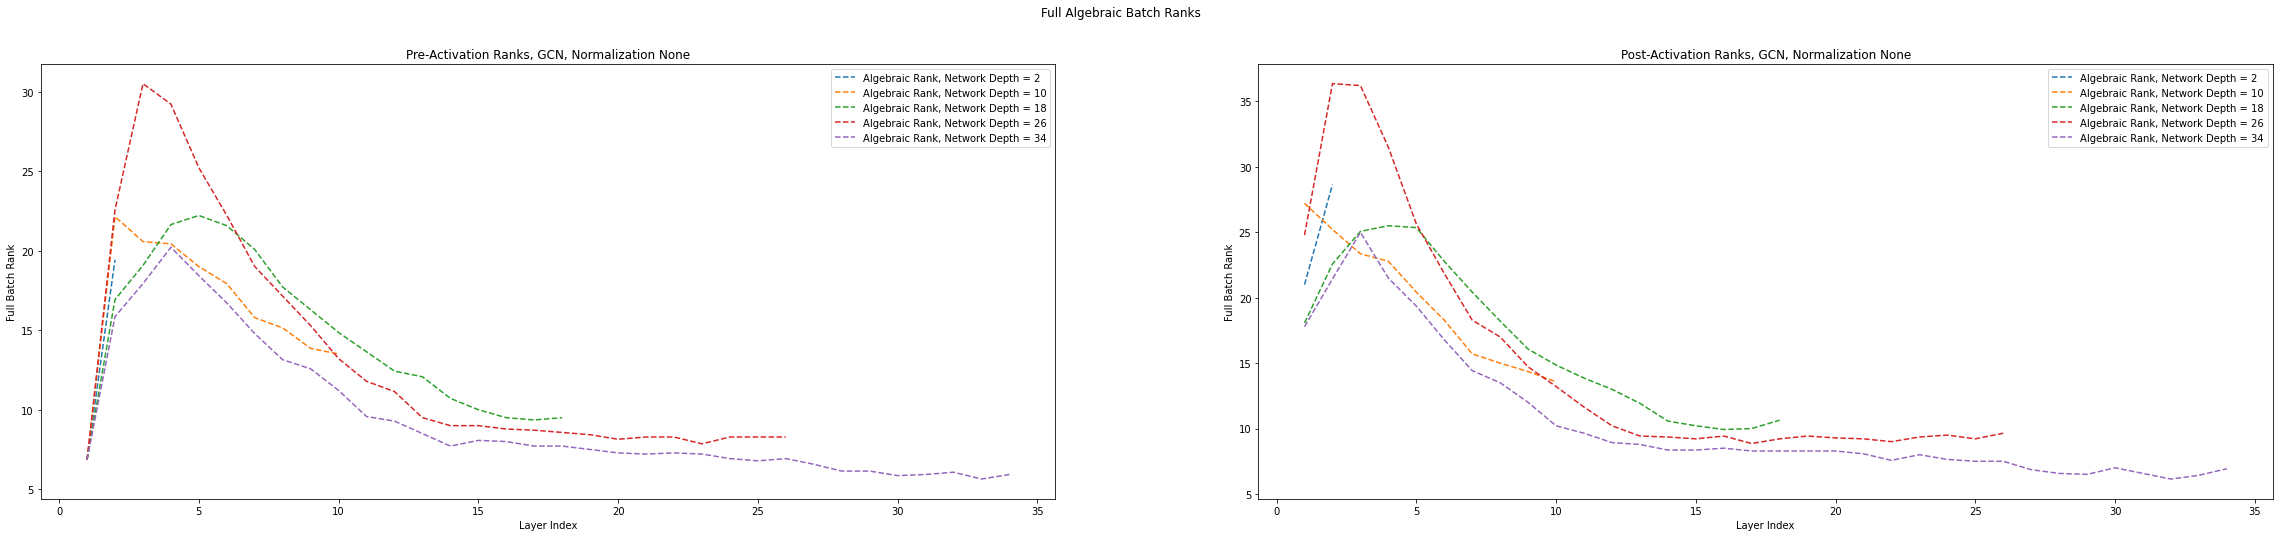

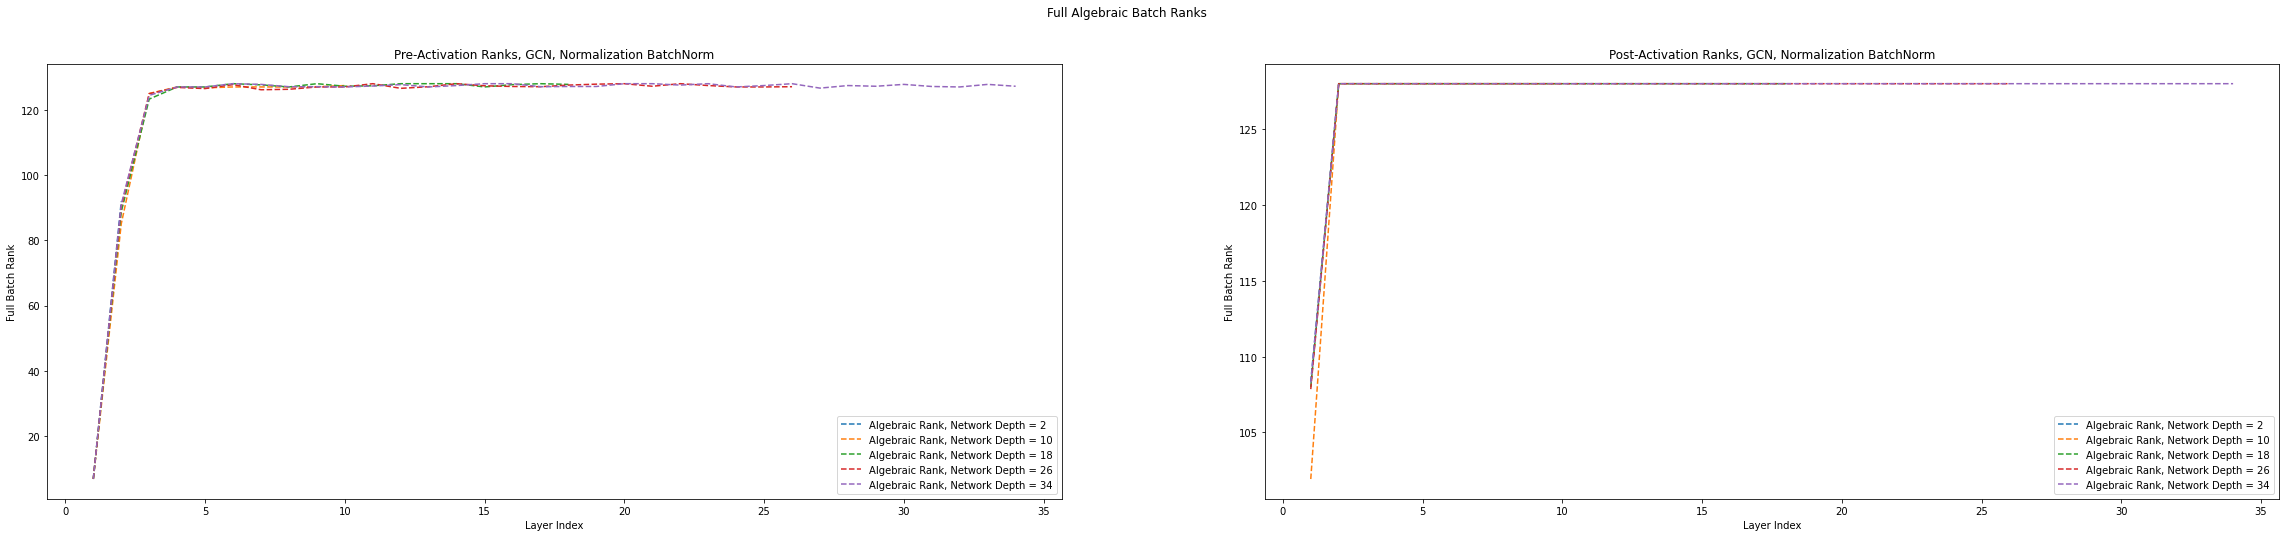

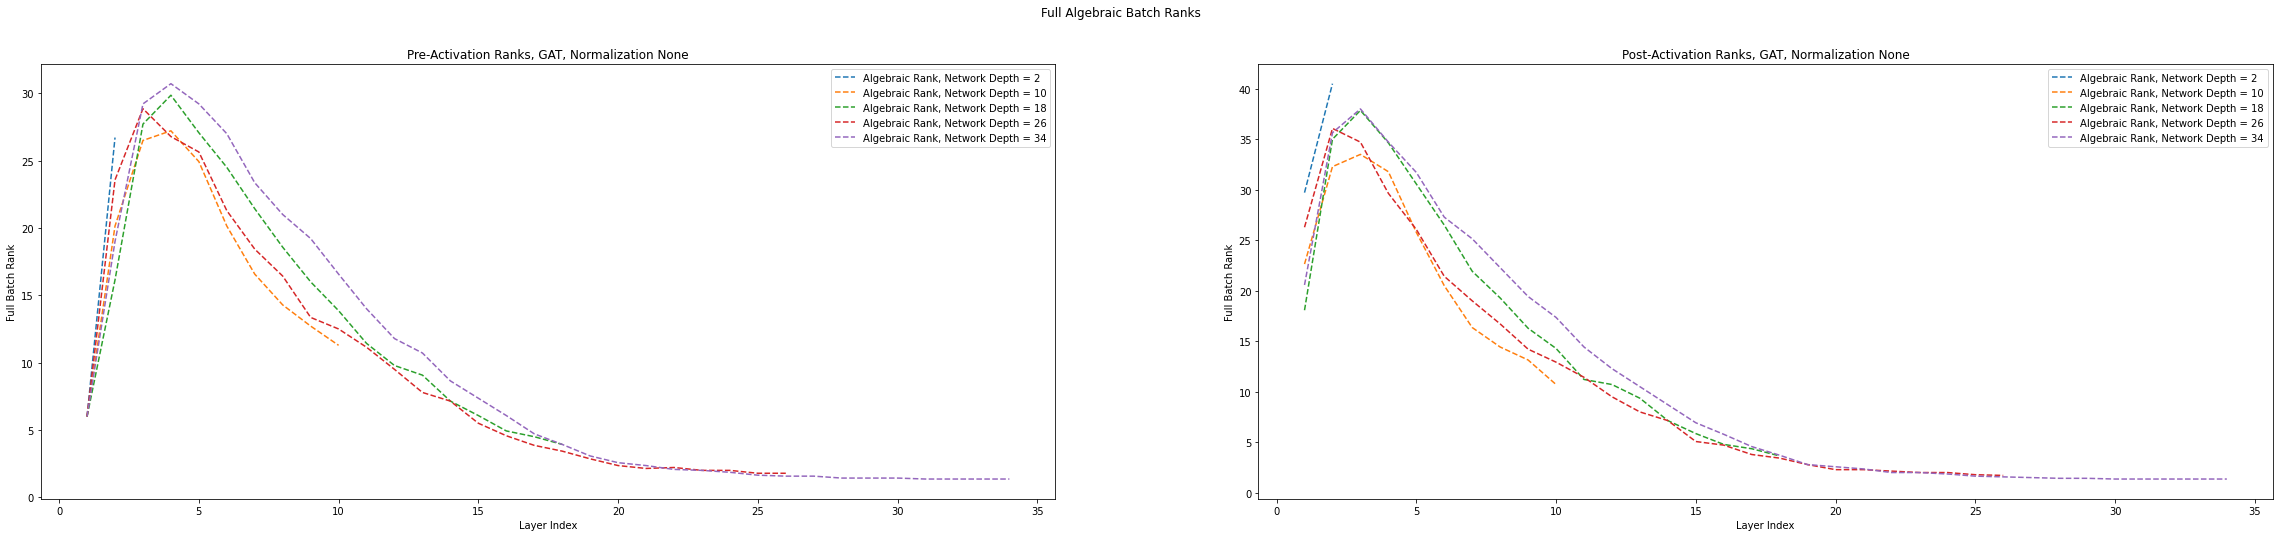

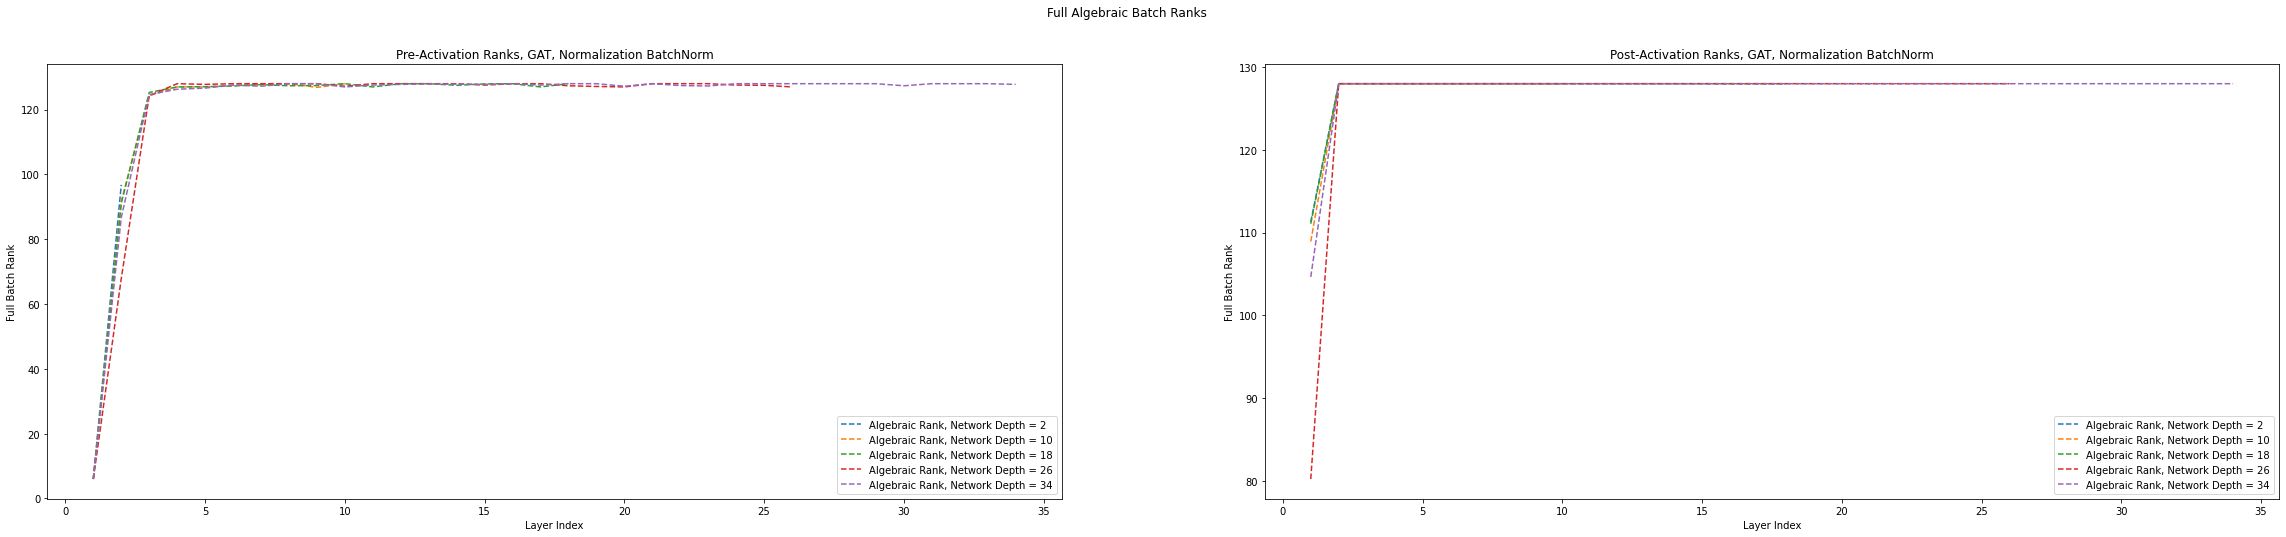

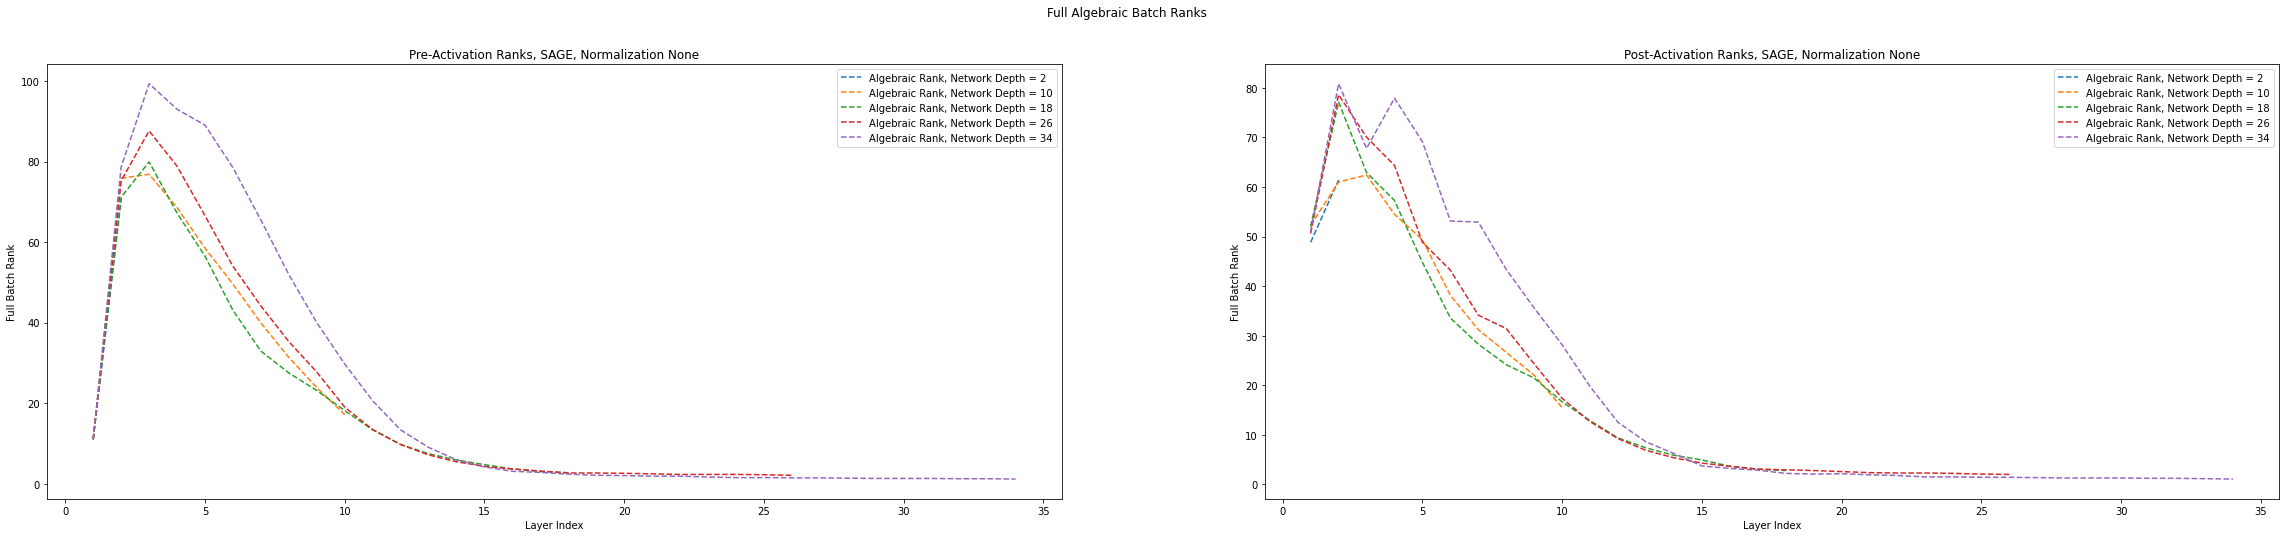

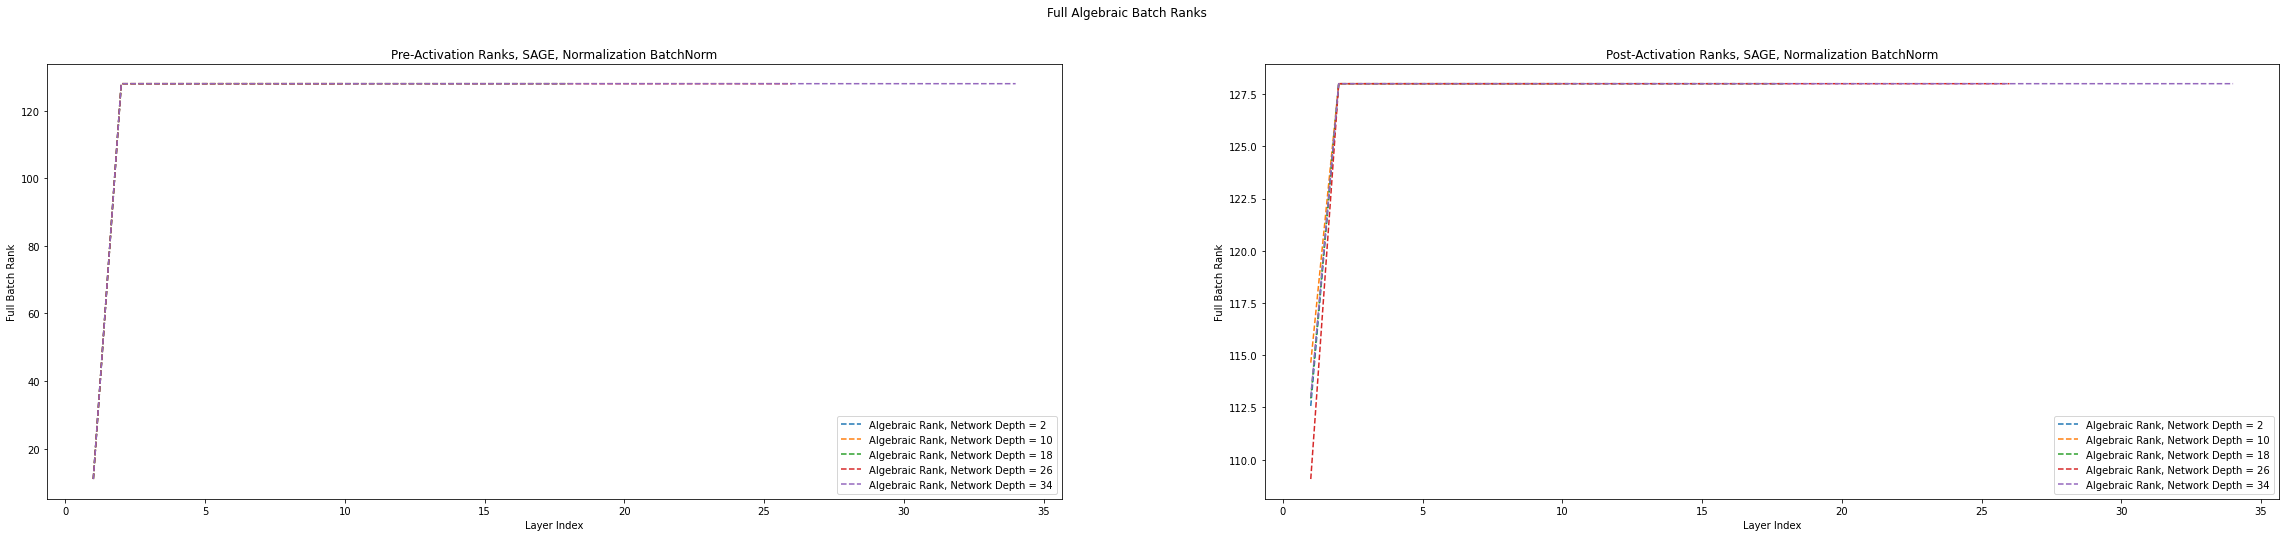

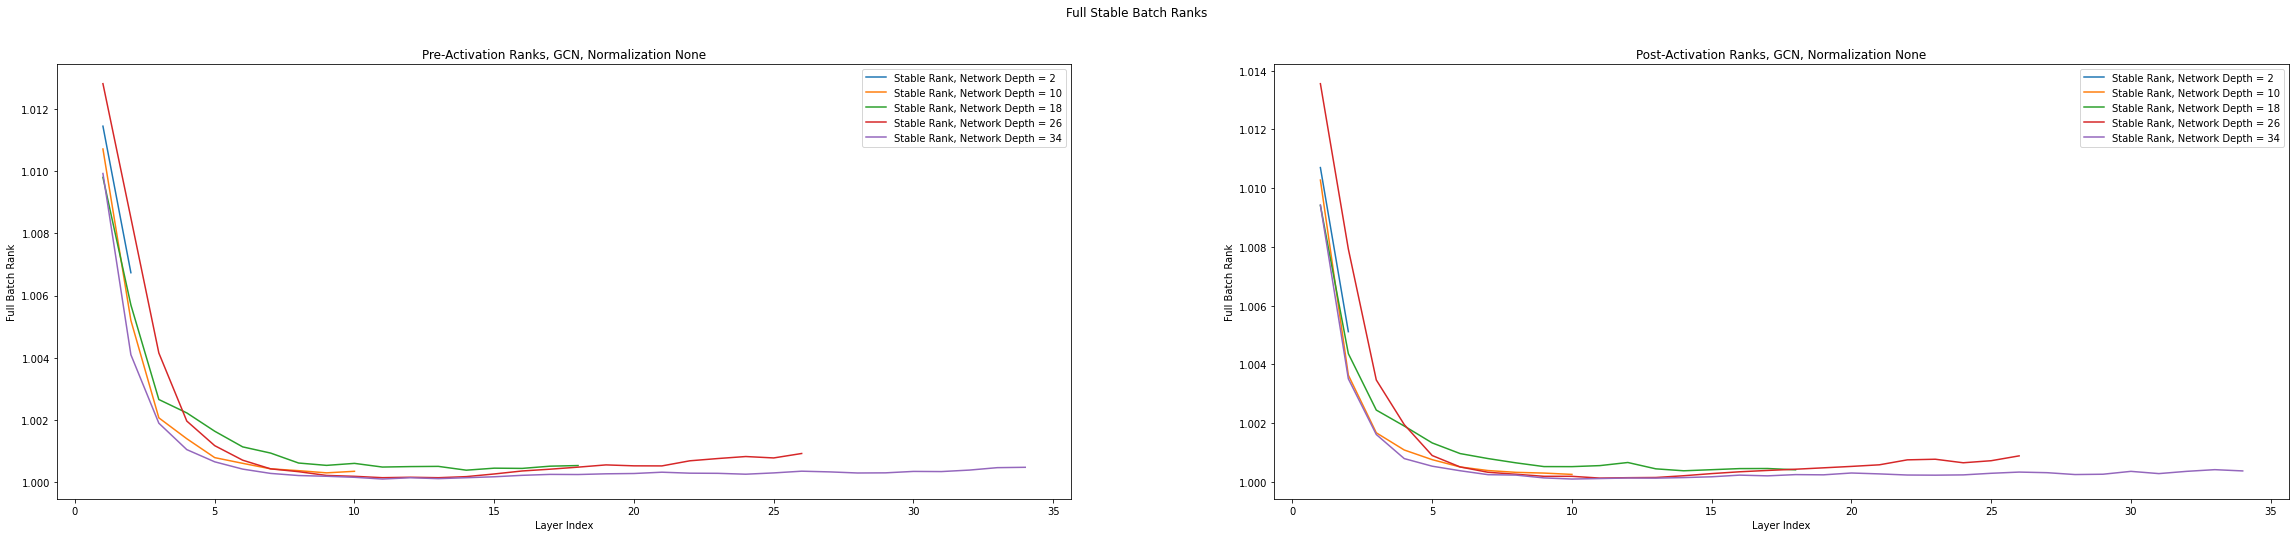

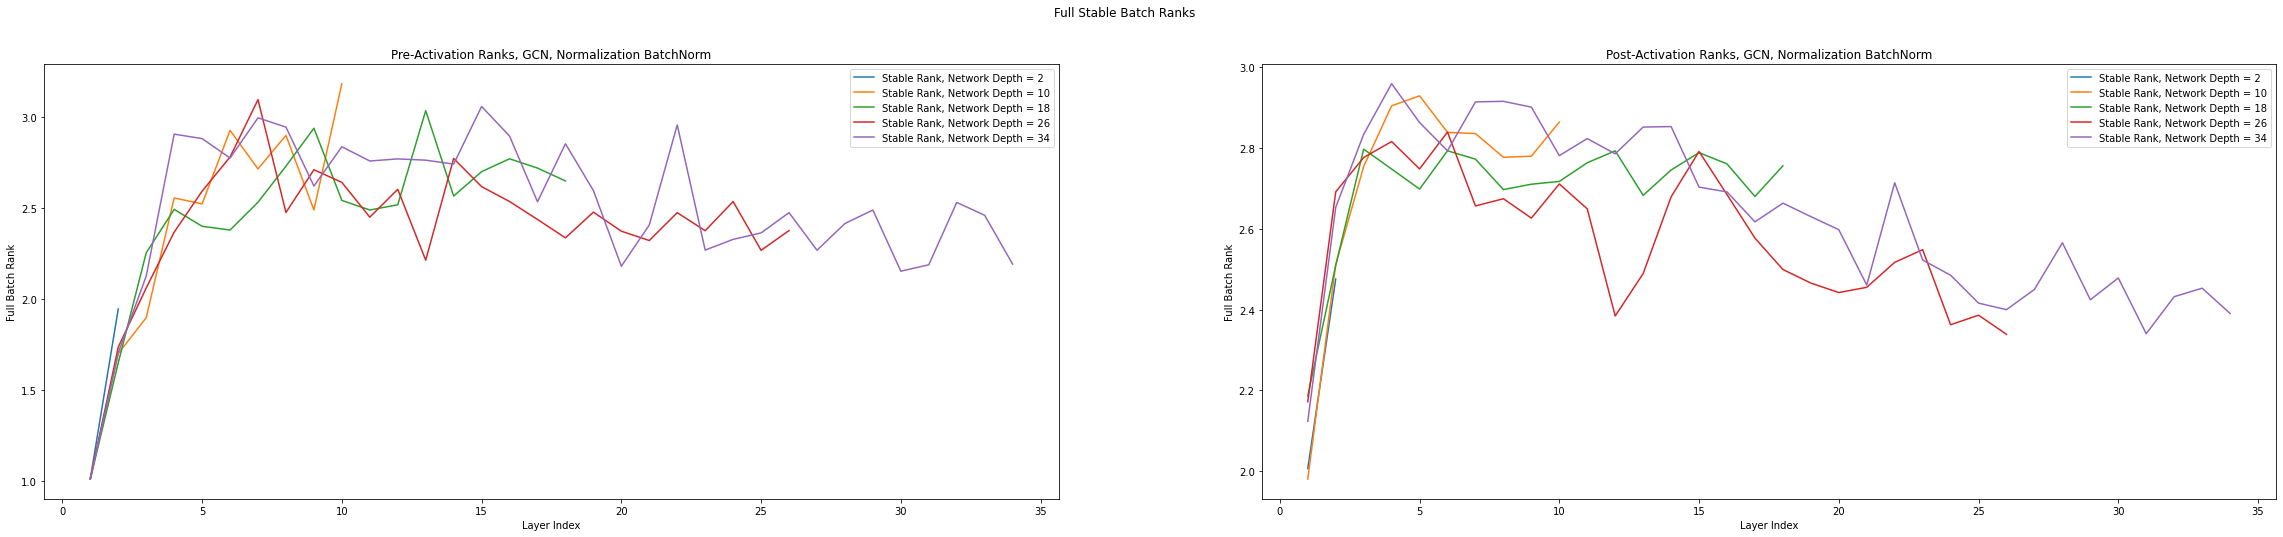

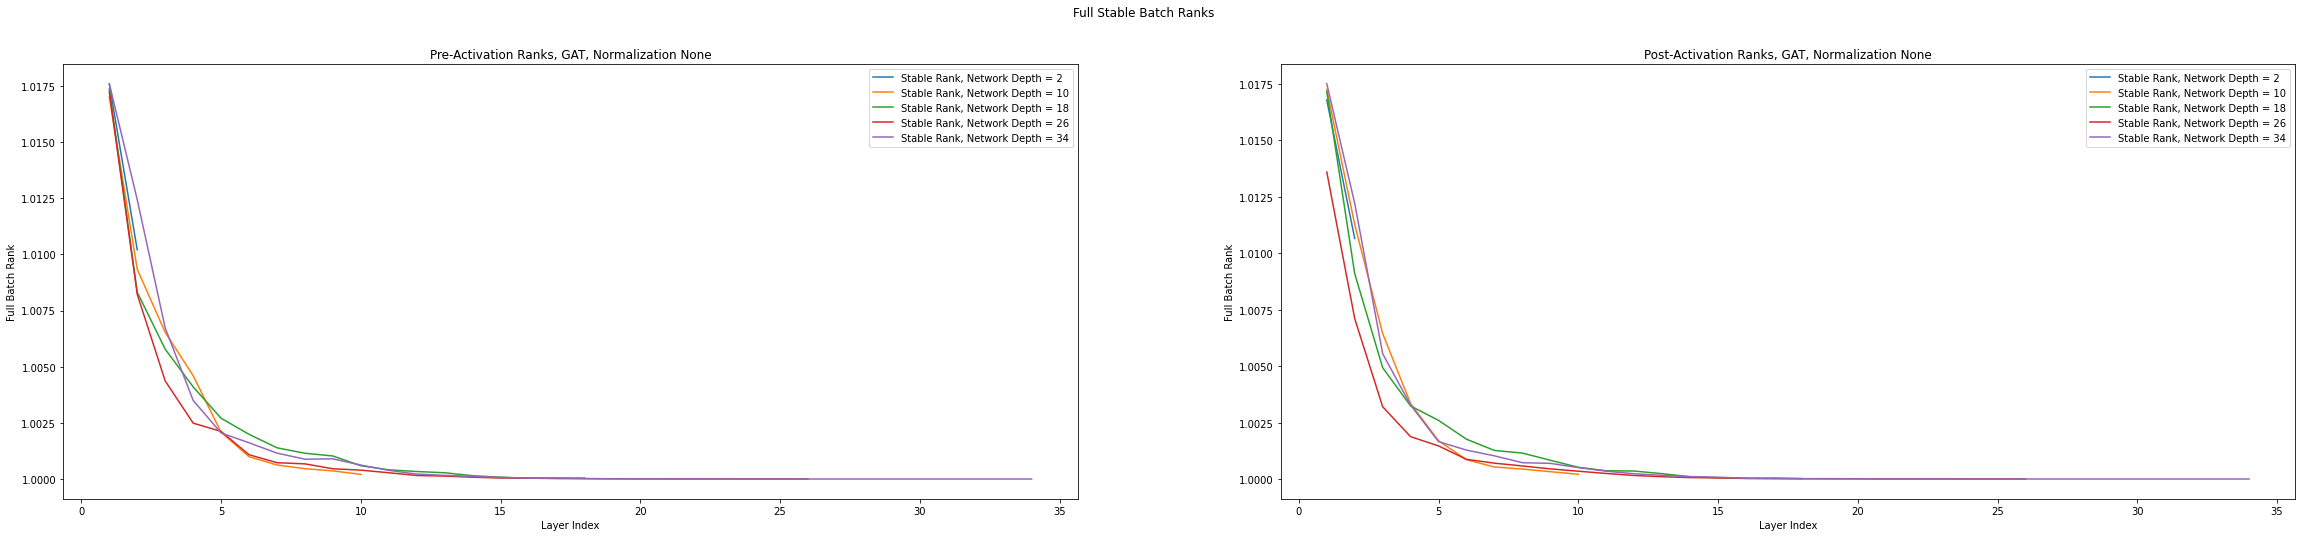

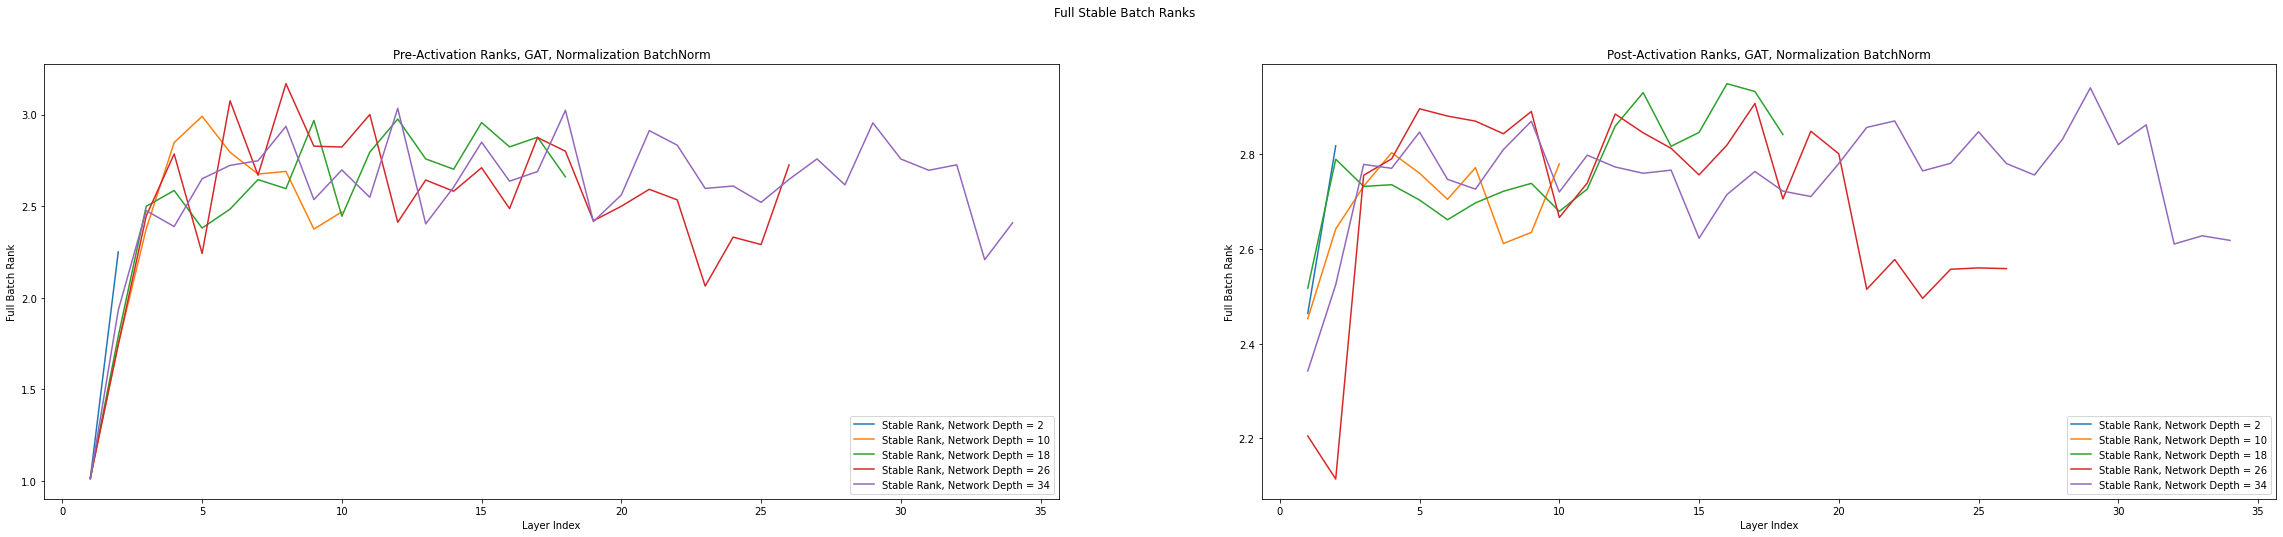

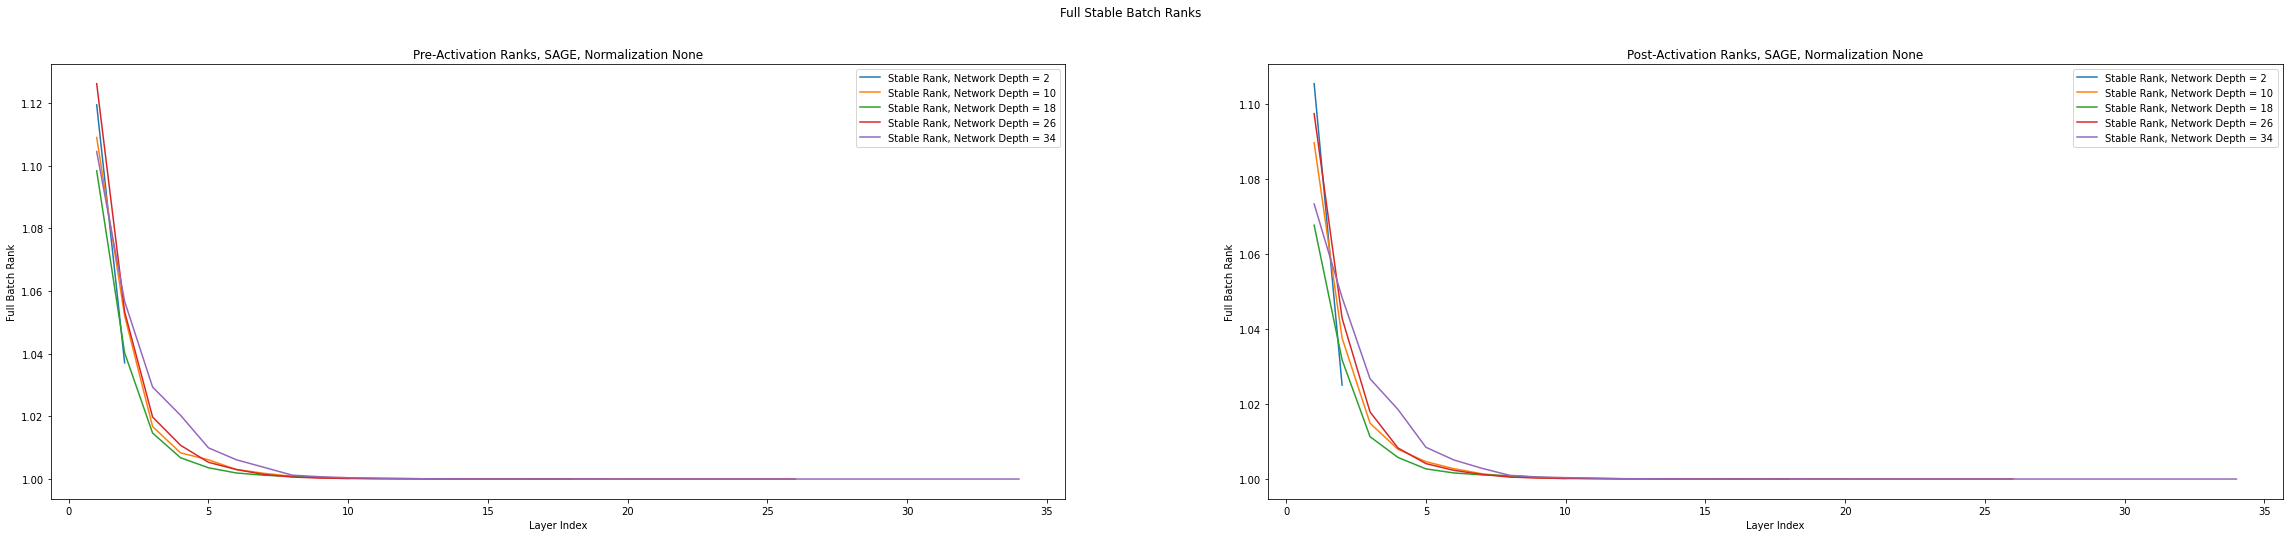

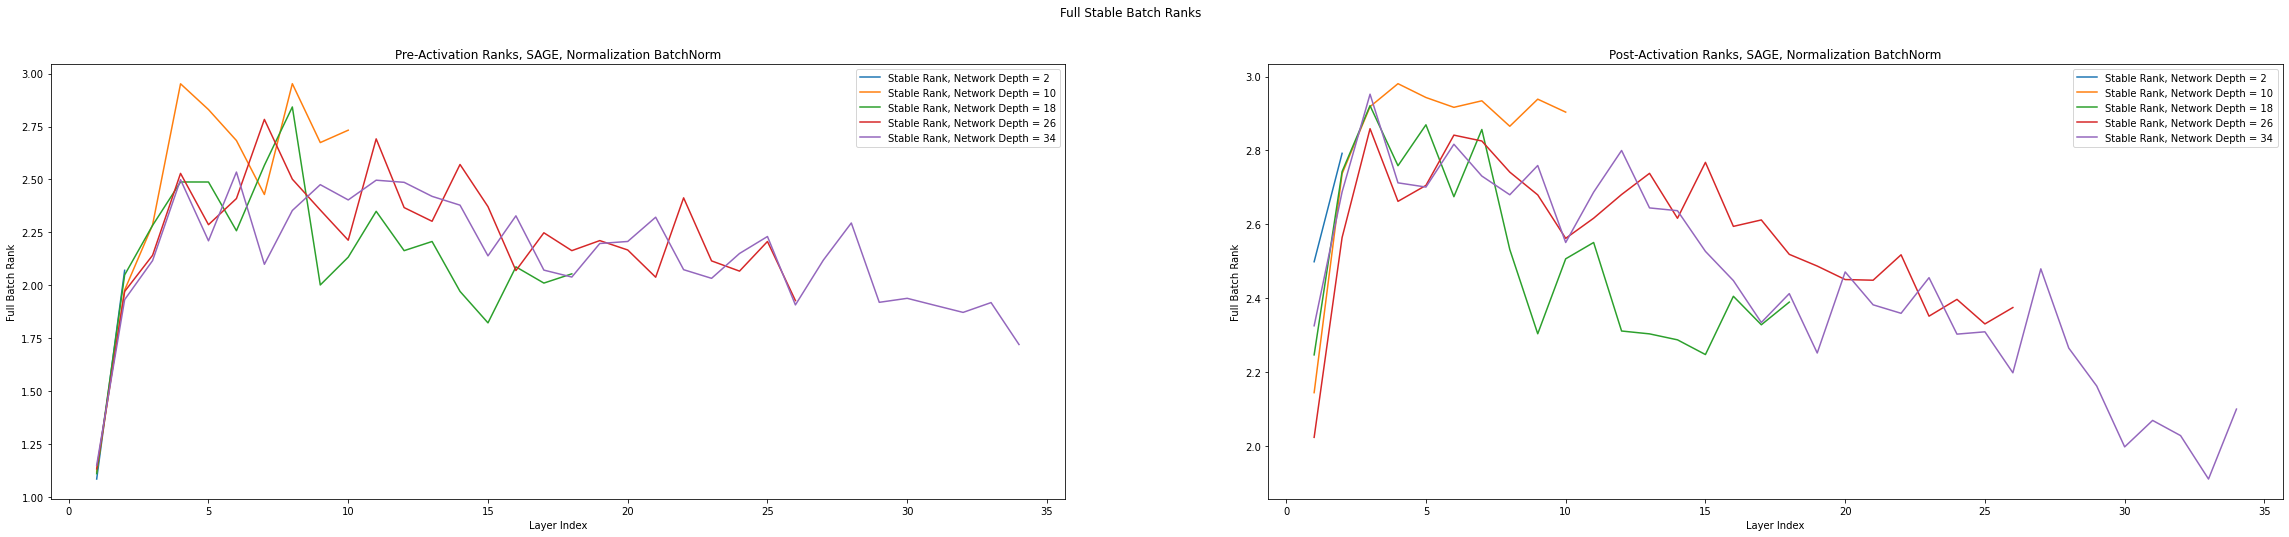

In [18]:
# X AXIS - Layer index
# Y AXIS - Full batch rank
# LABELS - Varying network depths
# FIXED - No normalization

conv = "GCN"

for norm in ['None', 'BatchNorm']:
    layers = torch.arange(1, 49)
    conv_alg_ranks = {d.item(): [np.nan for l in layers] for d in depths}
    activ_alg_ranks = {d.item(): [np.nan for l in layers] for d in depths}

    for m in metrics:
        if m.layer_type=='Activation' and m.normalization==norm and m.conv_type == conv:
            if m.name == 'batch_algebraic_ranks':
                activ_alg_ranks[m.depth.item()][m.layer_index] = m.value

        if m.layer_type=='Convolution' and m.normalization==norm and m.conv_type == conv:
            if m.name == 'batch_algebraic_ranks':
                conv_alg_ranks[m.depth.item()][m.layer_index] = m.value

        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 8))
    fig.suptitle('Full Algebraic Batch Ranks')
    ax1.set_title("Pre-Activation Ranks, {}, Normalization {}".format(conv, norm))
    ax1.set_xlabel("Layer Index")
    ax1.set_ylabel("Full Batch Rank")
    for k,v in conv_alg_ranks.items():
        ax1.plot(layers, v, linestyle="--", label="Algebraic Rank, Network Depth = {}".format(k))
    ax1.legend()

    ax2.set_title("Post-Activation Ranks, {}, Normalization {}".format(conv, norm))
    ax2.set_xlabel("Layer Index")
    ax2.set_ylabel("Full Batch Rank")
    for k,v in activ_alg_ranks.items():
        ax2.plot(layers, v, linestyle="--", label="Algebraic Rank, Network Depth = {}".format(k))
    ax2.legend()
    plt.show()


for norm in ['None', 'BatchNorm']:
    layers = torch.arange(1, 49)
    conv_stable_ranks = {d.item(): [np.nan for l in layers] for d in depths}
    activ_stable_ranks = {d.item(): [np.nan for l in layers] for d in depths}

    for m in metrics:
        if m.layer_type=='Activation' and m.normalization==norm and m.conv_type == conv:
            if m.name == 'batch_stable_ranks':
                activ_stable_ranks[m.depth.item()][m.layer_index] = m.value

        if m.layer_type=='Convolution' and m.normalization==norm and m.conv_type == conv:
            if m.name == 'batch_stable_ranks':
                conv_stable_ranks[m.depth.item()][m.layer_index] = m.value
        
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 8))
    fig.suptitle('Full Stable Batch Ranks')
    ax1.set_title("Pre-Activation Ranks, {}, Normalization {}".format(conv, norm))
    ax1.set_xlabel("Layer Index")
    ax1.set_ylabel("Full Batch Rank")
    for k,v in conv_stable_ranks.items():
        ax1.plot(layers, v, linestyle="-", label="Stable Rank, Network Depth = {}".format(k))
    ax1.legend()

    ax2.set_title("Post-Activation Ranks, {}, Normalization {}".format(conv, norm))
    ax2.set_xlabel("Layer Index")
    ax2.set_ylabel("Full Batch Rank")
    for k,v in activ_stable_ranks.items():
        ax2.plot(layers, v, linestyle="-", label="Stable Rank, Network Depth = {}".format(k))
    ax2.legend()
    plt.show()



In [7]:
initial_rank = []
initial_mean = []
initial_var = []
for d in train_loader:
    x = d.x.type(torch.FloatTensor)

    m = x.mean(dim=0)
    r = torch.linalg.matrix_rank(x)
    v = x.var(dim=0)
    initial_rank.append(r)
    initial_mean.append(m)
    initial_var.append(v)


initial_rank = sum(initial_rank) / len(initial_rank)
initial_mean = sum(initial_mean) / len(initial_mean)
initial_var = sum(initial_var) / len(initial_var)

print (initial_rank, initial_mean, initial_var)


tensor(12.) tensor([ 3.1682e+02,  3.2367e+02,  7.8436e+00,  1.2462e+01, -1.2203e-01,
         2.9807e+00,  4.7755e-01,  4.4755e+00,  2.6811e+00,  2.4589e+00,
         2.7717e+00,  1.7562e+00,  2.1210e+00,  2.4273e+00,  2.4385e+00,
         2.6993e+00,  2.0047e+00,  2.2828e+00,  2.1566e+00,  3.0739e+00,
         1.7562e+00,  4.7122e+02,  4.1025e-01,  2.1190e+01,  1.6611e-02,
         7.5205e+02,  6.5482e-01,  4.2336e+02,  3.6826e-01,  4.7922e-01,
         4.8973e-01,  3.1053e-02]) tensor([4.6364e+05, 4.6362e+05, 1.6822e+02, 8.1859e+01, 3.5141e-01, 1.3129e+01,
        1.6771e+00, 3.2222e+01, 1.0626e+01, 1.2471e+01, 1.1475e+01, 5.9828e+00,
        9.5607e+00, 1.1019e+01, 8.6327e+00, 1.0194e+01, 8.0029e+00, 1.0944e+01,
        9.6300e+00, 1.4425e+01, 5.9828e+00, 3.3245e+05, 5.2772e-04, 9.8799e+02,
        9.5188e-04, 8.2910e+05, 1.4194e-04, 2.7005e+05, 4.5440e-04, 2.4929e-01,
        2.4965e-01, 2.9945e-02])


In [ ]:
### TRAINING ###

epochs = 50
depths = torch.arange(3, 56, 12)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_channels = 64

metrics = []

# Training loop
# Iterate over different normalization types
# for norm_setting in [None, 'BatchNorm', 'GraphNorm', 'PairNorm']:
for norm_setting in tqdm([None, 'BatchNorm'], desc="Normalization Types", position=0):

    # Iterate over different model depths
    for depth in tqdm(depths, desc="Network Depth", position=1, leave=False):

        if norm_setting == 'BatchNorm' or norm_setting == 'GraphNorm':
                norm_args = {'in_channels': hidden_channels}
        else:
            norm_args = None

        # Define model, optimizer, and loss
        model = GraphNet(
            hidden_channels=hidden_channels, 
            num_input_features = dataset[0].x.shape[-1],
            num_layers=depth,
            conv_type="GCN", 
            task=task, 
            norm=norm_setting, 
            norm_args=norm_args
        ).to(device)        
        criterion = torch.nn.CrossEntropyLoss()

        for optimizer in tqdm([torch.optim.Adam(model.parameters(), lr=0.001), torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)], desc="Optimizer Type", position=2, leave=False):

            accuracies = {'test_acc': [], 'train_acc': []}

            # Training loop
            for epoch in tqdm(range(1, epochs+1), desc="Training Epoch", position=3, leave=False):
                train_regression(train_loader, model, criterion, optimizer, device)
                train_acc = test_regression(train_loader, model, criterion, device)
                test_acc = test_regression(test_loader, model, criterion, device)
                accuracies['test_acc'].append(test_acc)
                accuracies['train_acc'].append(train_acc)
                print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

            
            final_train_acc = TrainingMetric(
                depth=model.num_layers,
                normalization=str(model.norm),
                name="Training Accuracy",
                values=accuracies['train_acc'],
                optimizer=optimizer
            )
            final_test_acc = TrainingMetric(
                depth=model.num_layers,
                normalization=str(model.norm),
                name="Test Accuracy",
                values=accuracies['test_acc'],
                optimizer=optimizer
            )
            metrics.append(final_train_acc)
            metrics.append(final_test_acc)
            metrics += save_order_params(model, optimizer)
    

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Train Acc: 0.0113, Test Acc: 1.5193


KeyboardInterrupt: ignored

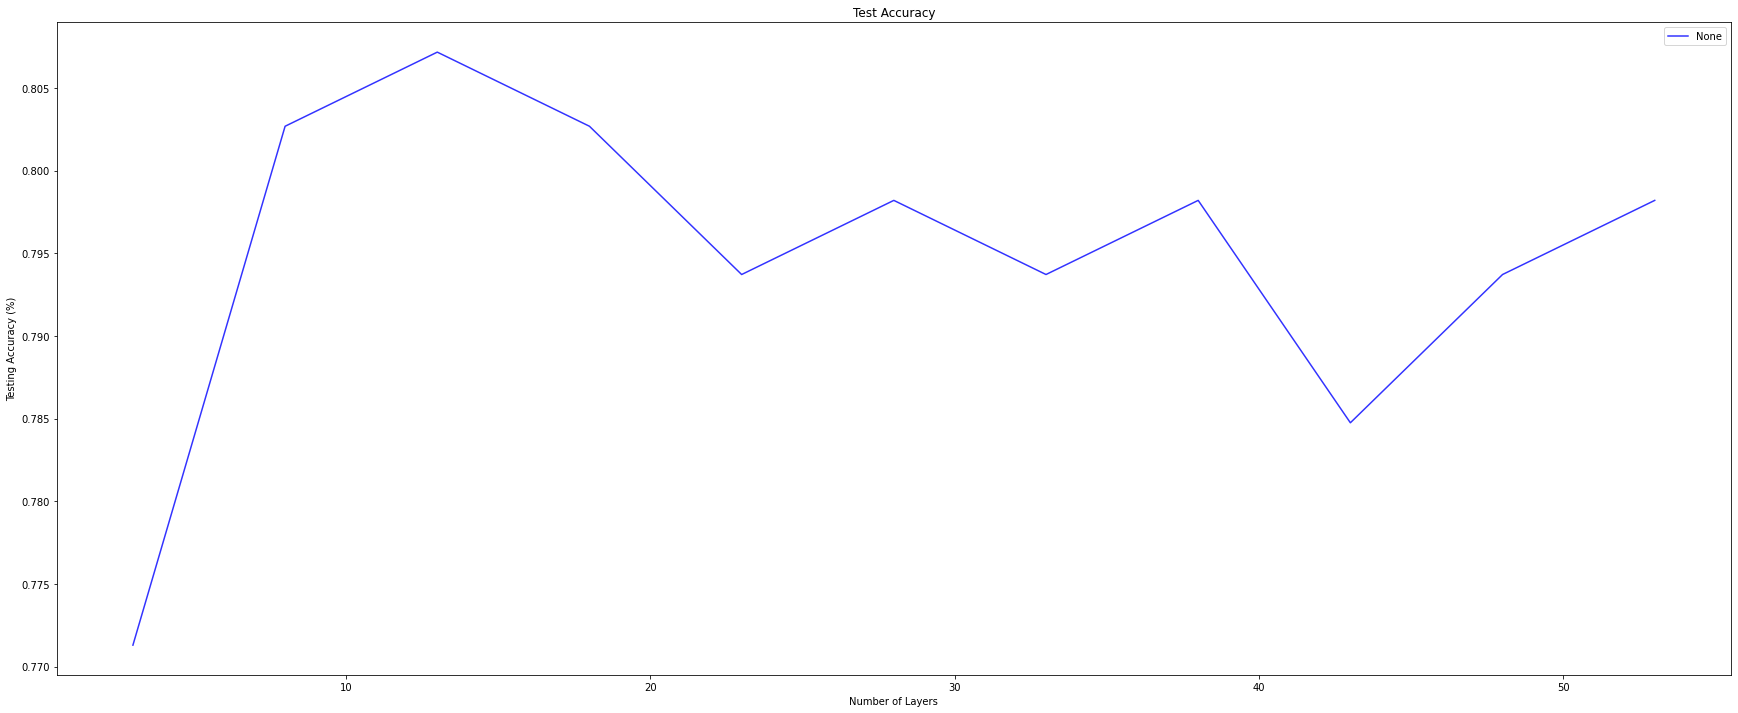

In [ ]:
# print (final_test_acc)

plt.figure(figsize=(30, 12))
plt.title('Test Accuracy')
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy (%)")

names = list(final_test_acc.keys())
norms = [n.split("_")[0] for n in names]
norms = [i for n, i in enumerate(norms) if i not in norms[:n]]

# for linestyle, norm in zip(['b', 'r', 'g', 'k'], norms):
for linestyle, norm in zip(['b'], norms):


    if norm != "DiffGroupNorm":

        Layer1 = []
        LayerF = []

        for depth in depths:

            depth = depth.item()

            Layer1.append(max(final_test_acc['{}_{}'.format(norm, depth)]))
            # LayerF.append(final_test_acc['{}_{}'.format(norm, depth)][depth-1])

        plt.plot(depths, Layer1, '{}-'.format(linestyle), markersize=3, alpha=0.8, label=norm)

        # plt.plot(depths, np.log10(LayerF), '{}s'.format(linestyle), markersize=3, alpha=0.3)


plt.legend()
plt.show()

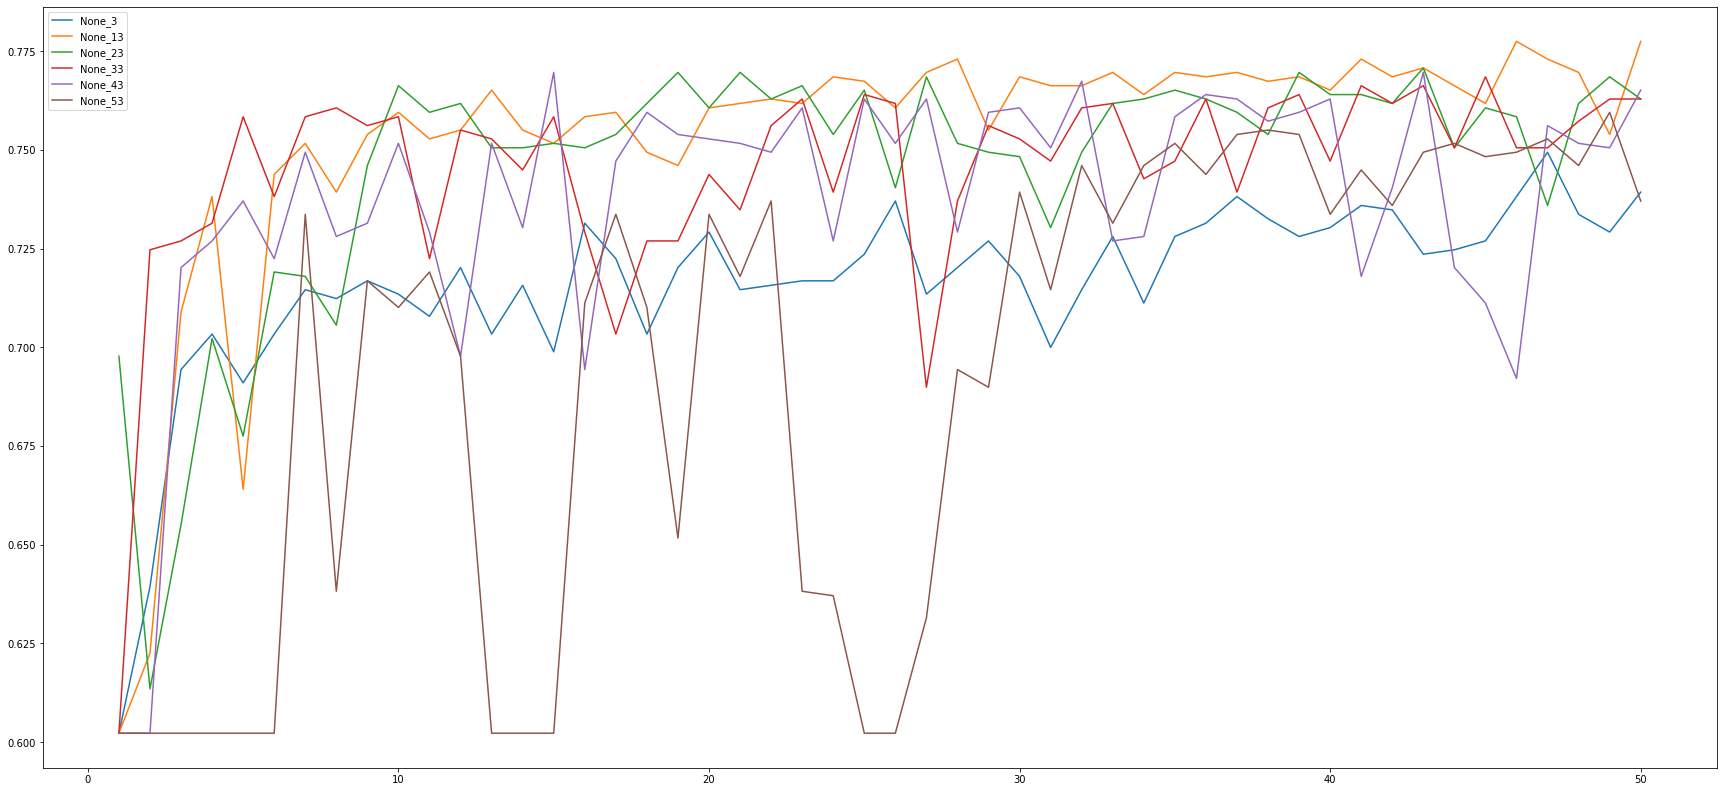

In [ ]:
plt.figure(figsize=(30, 14))
for idx, (k,v) in enumerate(final_train_acc.items()):
    if idx % 2 == 0:
        plt.plot([i for i in range(1, 51)], v, label=k)
plt.legend()
plt.show()

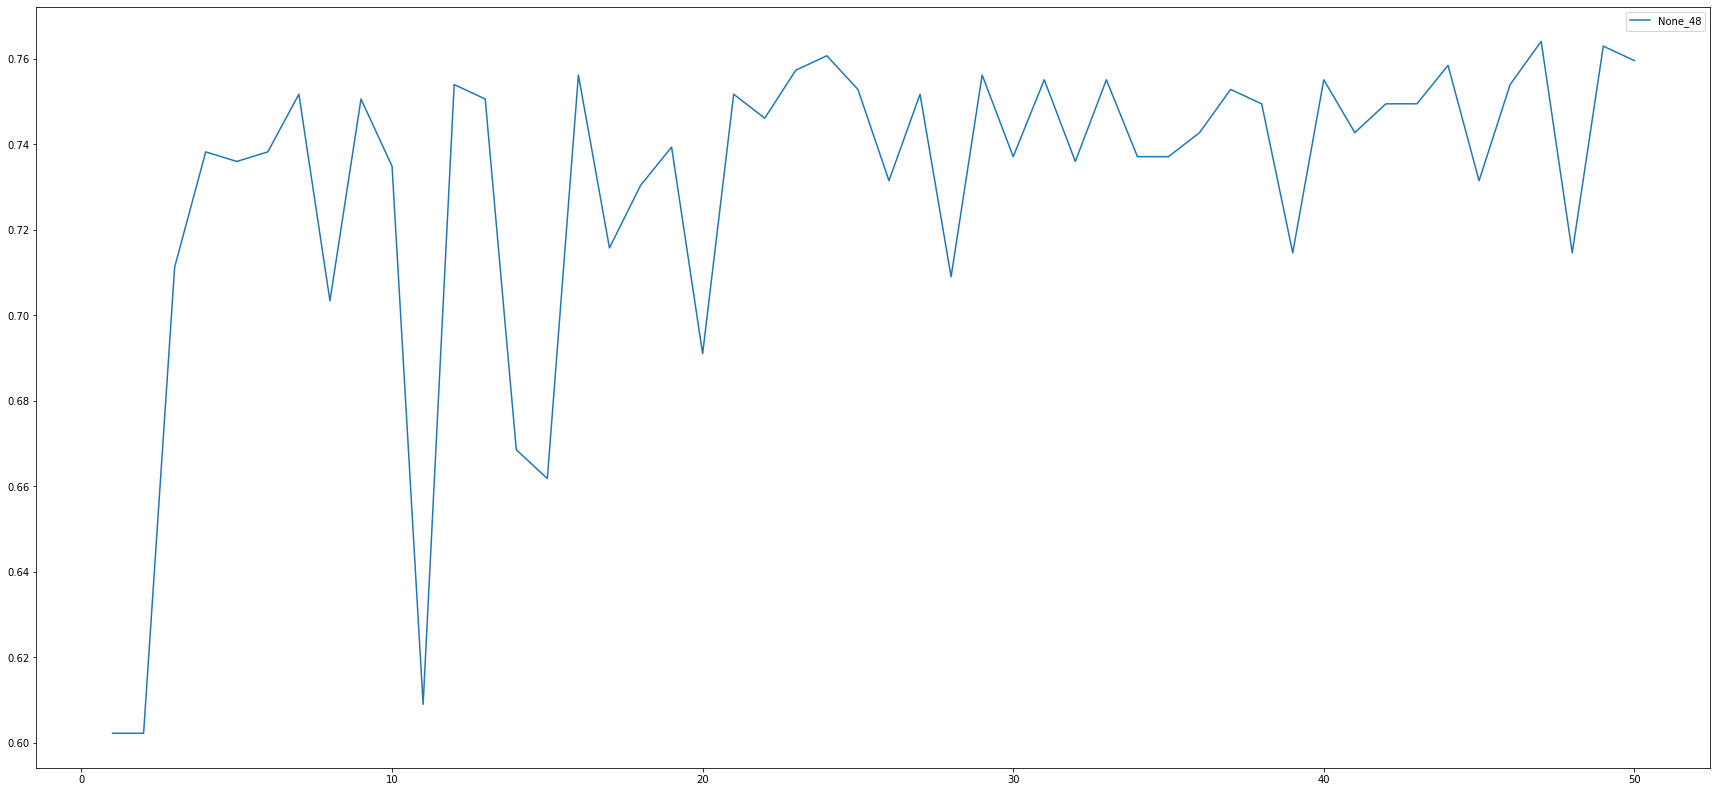

In [ ]:
plt.figure(figsize=(30, 14))
for idx, (k,v) in enumerate(final_train_acc.items()):
    if idx == 9:
        plt.plot([i for i in range(1, 51)], v, label=k)
plt.legend()
plt.show()